## Inspect Pipeline

In [31]:
from collections import defaultdict
import inspect
import pandas as pd
import numpy as np
from scipy import stats
import re
from graphviz import Digraph

from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

### 1. pandas

In [17]:
import inspect
import pandas as pd



def func_aggregation(pipeline_func):
    '''
    This function is used for line execution with exec()
    
    args:
        function strings after inspect
    returns:
        list of functionable strings for exec()
        (input params, executable lines, output) 
    '''
    func_str = inspect.getsource(pipeline_func)
    res = [] # executables for return
    stack_for_parent = [] # stack storing brackets for line integration
    logs_of_parent = [] # logs of lines for concat
#     convert function codes to list of strings
    func_list = [item.strip() for item in func_str.split('\n')]
#     function args
    func_args = [item.strip() for item in func_list[0].split('(')[1].rstrip('):').split(',')]
    for item in func_list[1:]:
        if not item:
            continue
        logs_of_parent.append(item)
        for char in item:
            if char == '(':
                stack_for_parent.append('(')
            if char == '[':
                stack_for_parent.append('[')
            if char == ')' and stack_for_parent[-1] == '(':
                stack_for_parent.pop(-1)
            if char == ']' and stack_for_parent[-1] == '[':
                stack_for_parent.pop(-1)
        if not stack_for_parent:
            res.append(''.join(logs_of_parent))
            logs_of_parent.clear()
    return func_args, res[:-1], [item.strip() for item in res[-1].replace('return ', '').split(',')]

def find_pd_lines(pipeline_func):
    pd_lines = []
    input_args , executable_list, _ = func_aggregation(pipeline_func)
    for line in input_args:
        exec(line)
    for cur_line in executable_list:
        exec(cur_line)
        try: 
            if str(eval(f"type({cur_line.split('=')[0].strip()})")) == "<class 'pandas.core.frame.DataFrame'>":
                pd_lines.append(cur_line)
        except:
            print("[ERROR]: error in finding pandas code")
    return pd_lines

In [18]:
import re

class DataFlowVertex:
    def __init__(self, parent_vertices, name, operation, params):
        self.parent_vertices = parent_vertices
        self.name = name
        self.operation = operation
        self.params = params
        
    def __repr__(self):
        return "(vertex_name={}: parent={}, op={}, params={})".format(self.name, self.parent_vertices, self.operation, self.params)
    
    def display(self):
        print("(vertex_name={}: parent={}, op={}, params={})".format(self.name, self.parent_vertices, self.operation, self.params))

def search_vertex_by_names(names, vertices_list):
    result = []
    for vertex in vertices_list:
        if vertex.name in names:
            result.append(vertex)
    return result


def pd_to_dataflow_graph(pipeline_func, parent_vertices=[]):
    executable_list = find_pd_lines(pipeline_func)
    graph = []
    previous = []
    
    for line in executable_list:
        var_name = line.split('=')[0].strip()

        # match ".func_name(...)"
        pd_func = re.search('\.\s*([_a-z]*)\s*\(',line)  
        if pd_func:
            func_name = pd_func.group(1)
            params = re.search('\(([^\)]*)\)',line)  #"(...)"
            
            if params:
                params = params.group(1).strip()

                if func_name == 'read_csv': #df = pd.read_csv(path)
                    vertex = DataFlowVertex(parent_vertices,var_name, func_name, params)
                    previous.append(vertex)

                elif func_name in ['join','merge','concat']:
                    if func_name == 'concat': #df_new = pd.concat([df1,df2],keys=[])
                        df_names = [name.strip() for name in params.strip('[]').split(',')]

                    else: # df_new = df1.join/merge(df2,on='...',how='...')
                        df_names = [re.split("[.=]",line)[1].strip(), params.split(',')[0].strip()]      
                    parent_vertices = search_vertex_by_names(df_names, graph) #search in graph by df_names
                    vertex = DataFlowVertex(previous, var_name, func_name, params) #TODO vertex name?
                    previous = [vertex]

                else:
                    vertex = DataFlowVertex(previous, func_name+' '+params, func_name, params)
                    previous = [vertex]


        # filter operation: "df[[cols]]", "df[condition]","df.loc[]","df.iloc[]"
        else:
            is_filter = re.search('\[([^\[\]]+)\]',line) #"[...]"
            if is_filter:
                filter_cond = is_filter.group(1)
                vertex = DataFlowVertex(previous, 'select '+filter_cond, 'filter', filter_cond)
                previous = [vertex]

        graph.append(vertex)
            
    return graph, previous

### 2. Sklearn --> Graph

In [19]:
def topo_sort(graph):
    adjacency_list = {vertex.name: [] for vertex in graph}
    visited = {vertex.name: False for vertex in graph}

    for vertex in graph:
        for parent_vertex in vertex.parent_vertices:
            adjacency_list[parent_vertex.name].append(vertex.name)

    output = []

    def toposort(vertex_name, adjacency_list, visited, output):
        visited[vertex_name] = True
        for child_name in adjacency_list[vertex_name]:
            if not visited[child_name]:
                toposort(child_name, adjacency_list, visited, output)
        output.append(vertex_name)

    for vertex_name in adjacency_list.keys():
        if not visited[vertex_name]:
            toposort(vertex_name, adjacency_list, visited, output)

    output.reverse()

    vertices_by_name = {vertex.name: vertex for vertex in graph}

    sorted_graph = []
    for vertex_name in output:
        sorted_graph.append(vertices_by_name[vertex_name])
    return sorted_graph


def find_sink(graph):
    sorted_graph = topo_sort(graph)
    return sorted_graph[-1]

def pipeline_to_dataflow_graph(pipeline, name_prefix='', parent_vertices=[]):
    graph = []
    parent_vertices_for_current_step = parent_vertices
    parent_vertices_for_next_step = []

    for step_name, component in pipeline.steps:
        component_class_name = component.__class__.__name__

        if component_class_name == 'ColumnTransformer':
            for transformer_prefix, transformer_component, columns in component.transformers:
                for column in columns:
                    name = name_prefix + step_name + '__' + transformer_prefix + "__" + column
                    transformer_component_class_name = transformer_component.__class__.__name__

                    if transformer_component_class_name == 'Pipeline':

                        vertices_to_add = pipeline_to_dataflow_graph(transformer_component,
                                                                     name + "__",
                                                                     parent_vertices_for_current_step)

                        for vertex in vertices_to_add:
                            graph.append(vertex)

                        parent_vertices_for_next_step.append(find_sink(vertices_to_add))

                    else:
                        vertex = DataFlowVertex(parent_vertices_for_current_step,
                                                name_prefix + name,
                                                transformer_component_class_name,
                                               '')
                        graph.append(vertex)
                        parent_vertices_for_next_step.append(vertex)

        else:
            vertex = DataFlowVertex(parent_vertices_for_current_step,
                                    name_prefix + step_name,
                                    component_class_name,
                                   '')
            graph.append(vertex)
            parent_vertices_for_next_step.append(vertex)

        parent_vertices_for_current_step = parent_vertices_for_next_step.copy()
        parent_vertices_for_next_step = []

    return graph

def sklearn_to_dataflow_graph(pipeline, parent_vertices=[]):
    
    graph = pipeline_to_dataflow_graph(pipeline, name_prefix='', parent_vertices=parent_vertices)
    return graph


## Visualize

In [20]:
from graphviz import Digraph

def visualize(nested_graph):
    dot = Digraph(comment='preprocessing_pipeline')

    for node in nested_graph:
        dot.node(node.name,label = node.name+',\nop='+node.operation)
        parents = node.parent_vertices 
        
        for parent in parents:
            dot.edge(parent.name, node.name)
    
    return dot


# Test

### 1) test on pandas df

In [21]:
###test dfs
countries = ['Germany', 'France', 'Indonesia']
inhabitants = [82.5 * 10**6, 66.9 * 10**6, 255.5 * 10**6]
capitals = ['Berlin', 'Paris', 'Jakarta']
to_drop = ['hi','hi','hi']

df1 = pd.DataFrame({'country': countries,
                    'inhabitant': inhabitants,
                    'capital': capitals,
                   'to_drop': to_drop})
df1 = df1[['country', 'capital', 'inhabitant','to_drop']]
print(df1)

countries = ['Germany', 'Italy', 'Spain', 'Austria']
capitals = ['Berlin', 'Rome', 'Madrid', 'Vienna']
hdis = [0.926, 0.897, 0.844, 0.893]
df2 = pd.DataFrame({'country': countries,
                    'capital': capitals,
                    'HDI': hdis})
df2 = df2[['country', 'capital', 'HDI']]
print(df2)

df1.to_csv ('../data/inhabitants.csv', index = None, header=True)
df2.to_csv ('../data/country.csv', index = None, header=True)


     country  capital   inhabitant to_drop
0    Germany   Berlin   82500000.0      hi
1     France    Paris   66900000.0      hi
2  Indonesia  Jakarta  255500000.0      hi
   country capital    HDI
0  Germany  Berlin  0.926
1    Italy    Rome  0.897
2    Spain  Madrid  0.844
3  Austria  Vienna  0.893


#### concat

/Users/huangbiao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


[(vertex_name=select df.HDI >= 0.9: parent=[(vertex_name=select 'country','HDI': parent=[(vertex_name=drop ['to_drop'],axis=1: parent=[(vertex_name=dropna : parent=[(vertex_name=concat_df: parent=[(vertex_name=inhabitants: parent=[], op=read_csv, params='../data/inhabitants.csv'), (vertex_name=country: parent=[], op=read_csv, params='../data/country.csv')], op=concat, params=[inhabitants, country])], op=dropna, params=)], op=drop, params=['to_drop'],axis=1)], op=filter, params='country','HDI')], op=filter, params=df.HDI >= 0.9)]


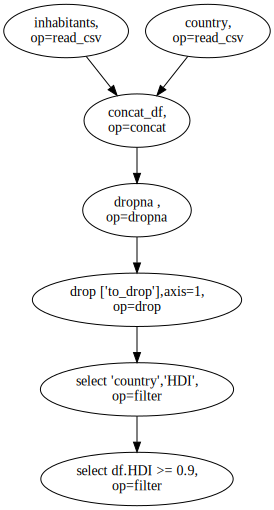

In [22]:
def test_pd_1():
    inhabitants = pd.read_csv('../data/inhabitants.csv')
    country = pd.read_csv('../data/country.csv')
    concat_df = pd.concat([inhabitants, country])
    df = concat_df.dropna()
    df = df.drop(['to_drop'],axis=1)
    df = df[['country','HDI']]
    df = df[df.HDI >= 0.9]
    return df

graph, parent_vertics = pd_to_dataflow_graph(test_pd_1)
print(parent_vertics)
visualize(graph)

#### merge

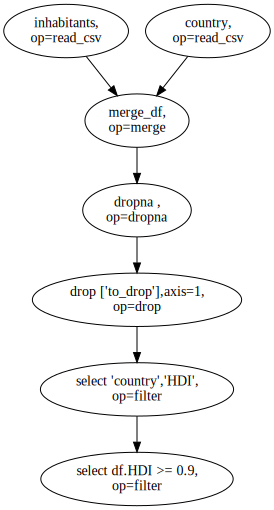

In [23]:
def test_pd_2():
    inhabitants = pd.read_csv('../data/inhabitants.csv')
    country = pd.read_csv('../data/country.csv')
    merge_df = inhabitants.merge(country, on='country', how='inner')
    df = merge_df.dropna()
    df = df.drop(['to_drop'],axis=1)
    df = df[['country','HDI']]
    df = df[df.HDI >= 0.9]
    return df

graph, parent_vertics = pd_to_dataflow_graph(test_pd_2)
visualize(graph)

#### sklearn + pandas

In [24]:
import pandas as pd 
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.compose import ColumnTransformer

def pipeline_test_hwk3_3(f_path = '../pipelines/adult-sample.csv', a = 0):
   
    raw_data = pd.read_csv(f_path, na_values='?')   
    data = raw_data.dropna()     

    labels = label_binarize(data['income-per-year'], ['>50K', '<=50K'])

    feature_transformation = sklearn.compose.ColumnTransformer(transformers=[
        ('categorical', OneHotEncoder(handle_unknown='ignore'), ['education', 'workclass']),
        ('numeric', StandardScaler(), ['age', 'hours-per-week'])
    ])

        
    income_pipeline = Pipeline([
      ('features', feature_transformation),
      ('classifier', DecisionTreeClassifier())])
    
    return income_pipeline

def pipeline_test_hwk3_4(f_path = 'data/adult-sample.csv', a = 0):
    raw_data = pd.read_csv(f_path, na_values='?')    #
    data = raw_data.dropna()     #

    labels = label_binarize(data['income-per-year'], ['>50K', '<=50K'])

    nested_categorical_feature_transformation = Pipeline(steps=[
        ('impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('encode', OneHotEncoder(handle_unknown='ignore'))
    ])

    nested_feature_transformation = ColumnTransformer(transformers=[
        ('categorical', nested_categorical_feature_transformation, ['education', 'workclass']),
        ('numeric', StandardScaler(), ['age', 'hours-per-week'])
    ])

    nested_pipeline = Pipeline([
      ('features', nested_feature_transformation),
      ('classifier', DecisionTreeClassifier())])

    return nested_pipeline


In [32]:
def adult_pipeline_normal(f_path = '../pipelines/adult-sample_missing.csv'):
    raw_data = pd.read_csv(f_path, na_values='?')
    data = raw_data.dropna()

    labels = label_binarize(data['income-per-year'], ['>50K', '<=50K'])

    nested_categorical_feature_transformation = Pipeline(steps=[
        ('impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('encode', OneHotEncoder(handle_unknown='ignore'))
    ])

    nested_feature_transformation = ColumnTransformer(transformers=[
        ('categorical', nested_categorical_feature_transformation, ['education', 'workclass']),
        ('numeric', StandardScaler(), ['age', 'hours-per-week'])
    ])

    nested_pipeline = Pipeline([
      ('features', nested_feature_transformation),
      ('classifier', DecisionTreeClassifier())])

    return nested_pipeline

In [33]:
pd_graph, parent_vertices = pd_to_dataflow_graph(adult_pipeline_normal)

print('parent_vertices', parent_vertices)
print('==========')
sklearn_pipeline = adult_pipeline_normal()
sklearn_graph = sklearn_to_dataflow_graph(sklearn_pipeline,parent_vertices)


parent_vertices [(vertex_name=dropna : parent=[(vertex_name=raw_data: parent=[], op=read_csv, params=f_path, na_values='?')], op=dropna, params=)]


KeyError: 'dropna '

In [26]:
pd_graph.extend(sklearn_graph)
pd_graph

[(vertex_name=raw_data: parent=[], op=read_csv, params=f_path, na_values='?'),
 (vertex_name=dropna : parent=[(vertex_name=raw_data: parent=[], op=read_csv, params=f_path, na_values='?')], op=dropna, params=),
 (vertex_name=features__categorical__education: parent=[(vertex_name=dropna : parent=[(vertex_name=raw_data: parent=[], op=read_csv, params=f_path, na_values='?')], op=dropna, params=)], op=OneHotEncoder, params=),
 (vertex_name=features__categorical__workclass: parent=[(vertex_name=dropna : parent=[(vertex_name=raw_data: parent=[], op=read_csv, params=f_path, na_values='?')], op=dropna, params=)], op=OneHotEncoder, params=),
 (vertex_name=features__numeric__age: parent=[(vertex_name=dropna : parent=[(vertex_name=raw_data: parent=[], op=read_csv, params=f_path, na_values='?')], op=dropna, params=)], op=StandardScaler, params=),
 (vertex_name=features__numeric__hours-per-week: parent=[(vertex_name=dropna : parent=[(vertex_name=raw_data: parent=[], op=read_csv, params=f_path, na_va

In [27]:
len(pd_graph)

7

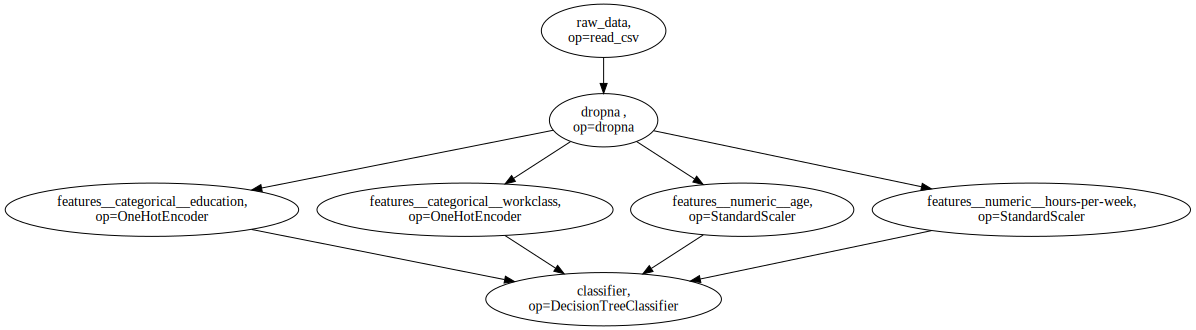

In [28]:
visualize(pd_graph)